# Overview

Notebook utilized to transform all scraped HTML pages into data frames to be utilized in the regression models. The salary section is missing some transformations, as I appared to have forgotten to save my changes. I can reproduce the work if necessary.

In [94]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import requests
import time
import os
from selenium.webdriver.common.by import By
import pickle
import re
import baseball as bb
import cpi # consumer price index library

In [95]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
PATH_S = '/Users/jadams/ds/metis/baseball_lin_regression/data/processed_df/salary.csv'
PATH_R = '/Users/jadams/ds/metis/baseball_lin_regression/data/processed_df/rookies.csv'
PATH_RS = '/Users/jadams/ds/metis/baseball_lin_regression/data/processed_df/rookie_stats.csv'
PATH_PLAYER_PAGES = '/Users/jadams/ds/metis/baseball_lin_regression/data/rookie_player_pages.csv'
PATH_PARTITION = '/Users/jadams/ds/metis/baseball_lin_regression/data/rookie_player_partition'

#### Build rookie master table

In [15]:
# print(rookie_player_pages.shape)
rookie_pages = pd.read_csv('data/rookie_pages.csv', index_col=0)

In [16]:
rookie_df = bb.build_rookie_table(rookie_pages)
rookie_df.head()

,Name,Debut,Age,Tm,rookie_year
0,Ricky Adams,1982-09-15,26,SFG,1985
1,Rick Aguilera,1985-06-12,23,NYM,1985
2,Doug Baker,1984-07-02,24,DET,1985
3,Jay Baller,1982-09-19,24,CHC,1985
4,Jeff Barkley,1984-09-16,25,CLE,1985


In [17]:
rookie_df.to_csv(PATH_R)

In [20]:
rookie_df.Name.value_counts().head()

Carlos Martinez    3
Kevin Brown        3
Craig Wilson       3
Mark Johnson       3
Luis Lopez         3
Name: Name, dtype: int64

In [22]:
rookie_df[rookie_df.Name == 'Kevin Brown']

,Name,Debut,Age,Tm,rookie_year
15,Kevin Brown,1986-09-30,24,TEX,1989
21,Kevin Brown,1990-07-27,25,MIL,1991
14,Kevin Brown,1996-09-12,27,MIL,2000


Name is not a unique identifier for a rookier. Let's see if the combination of name and rookie year is a way to identify a rookie.

In [25]:
rookie_df['name_rookie_year'] = rookie_df.Name + '_' + rookie_df.rookie_year.astype(str)
rookie_df.name_rookie_year.value_counts().head()

Tony Pena_2007         2
Jason Phillips_2003    2
Keith Miller_1989      2
Ryan Braun_2007        2
Ken Harvey_2003        1
Name: name_rookie_year, dtype: int64

In [26]:
rookie_df[rookie_df.name_rookie_year == 'Tony Pena_2007']

,Name,Debut,Age,Tm,rookie_year,name_rookie_year
123,Tony Pena,2006-04-13,26,KCR,2007,Tony Pena_2007
124,Tony Pena,2006-07-18,25,ARI,2007,Tony Pena_2007


The concatenation of name and rookie year does not make a unique identifier. Let's now try name and debut.

In [27]:
rookie_df.drop('name_rookie_year', axis=1, inplace=True)

In [31]:
rookie_df['name_debut'] = rookie_df.Name + '_' + rookie_df.Debut.astype(str)
rookie_df.name_debut.value_counts().sort_values(ascending=False).head()

Rick Reed_1988-08-08           1
Willie Adams_1996-06-11        1
Carl Edwards Jr._2015-09-07    1
Brian Stokes_2006-09-03        1
Lane Adams_2014-09-01          1
Name: name_debut, dtype: int64

In [70]:
rookie_df.to_csv(PATH_R)

NameError: name 'rookie_df' is not defined

#### Build rookie stats table

In [4]:
rookie_players = pd.read_csv('data/rookie_player_pages.csv', index_col=0)
rookie_players.reset_index(inplace=True)

In [93]:
for ind in range(1000,6000):
    bb.get_player_data(rookie_players.html[ind], rookie_players.year[ind], rookie_players.name[ind])
    if ind % 10 == 0:
        print('Processed row:', ind, end='\r')
    

KeyError: 5318

In [97]:
df_stats = pd.read_csv(PATH_RS, index_col=0)

print(df_stats.shape)

df_stats['name_tm'] = df_stats.name + '_' + df_stats.Tm
df_stats.name_tm.value_counts().sort_values(ascending=False).head()

(2584, 23)


Matt Luke_LAD           2
Mike Baxter_NYM         1
Jason Bourgeois_HOU     1
Omar Quintanilla_COL    1
Gustavo Molina_NYY      1
Name: name_tm, dtype: int64

In [98]:
df_stats.head()

,Year,Age,Tm,Lg,G,PA,AB,R,H,SB,...,3B,RBI,BB,SO,Awards,position,name,debut,award_count,name_tm
12,1985,26.0,SFG,NL,54.0,130.0,121.0,12.0,23.0,1.0,...,1.0,10.0,5.0,23.0,NaN,"Shortstop, Third Baseman and Second Baseman",Ricky Adams,1982-09-15,0,Ricky Adams_SFG
5,1985,24.0,DET,AL,15.0,27.0,27.0,4.0,5.0,0.0,...,0.0,1.0,0.0,9.0,NaN,Shortstop and Second Baseman,Doug Baker,1984-07-02,0,Doug Baker_DET
17,1985,27.0,CLE,AL,31.0,73.0,67.0,5.0,12.0,0.0,...,0.0,7.0,3.0,9.0,NaN,Catcher,Butch Benton,1978-09-14,0,Butch Benton_CLE
6,1985,22.0,CHW,AL,95.0,248.0,232.0,20.0,53.0,8.0,...,1.0,15.0,14.0,44.0,NaN,Outfielder,Daryl Boston,1984-05-13,0,Daryl Boston_CHW
8,1985,24.0,LAD,NL,24.0,63.0,53.0,4.0,7.0,0.0,...,0.0,6.0,7.0,10.0,NaN,First Baseman,Sid Bream,1983-09-01,0,Sid Bream_LAD


In [99]:
df_stats = pd.read_csv(PATH_RS, index_col=0)
agg_df_stats = df_stats.groupby(['Year', 'Age', 'name', 'debut', 'position']).sum().reset_index()

In [100]:
agg_df_stats.G.sort_values(ascending=False).head()

1317    163.0
588     162.0
1569    162.0
1118    161.0
172     161.0
Name: G, dtype: float64

In [101]:
agg_df_stats.loc[1317] # confirmed on br that matsui played 163 games

Year                                        2003
Age                                           29
name                               Hideki Matsui
debut                                 2003-03-31
position       Leftfielder and Designated Hitter
G                                            163
PA                                           695
AB                                           623
R                                             82
H                                            179
SB                                             2
BA                                         0.287
HR                                            16
TB                                           271
2B                                            42
3B                                             1
RBI                                          106
BB                                            63
SO                                            86
award_count                                    2
Name: 1317, dtype: o

In [102]:
agg_df_stats.HR.sort_values(ascending=False).head()

2423    52.0
143     49.0
2388    39.0
1118    37.0
2199    36.0
Name: HR, dtype: float64

In [103]:
agg_df_stats.loc[2423] # confirmed on br

Year                   2017
Age                      25
name            Aaron Judge
debut            2016-08-13
position       Rightfielder
G                       155
PA                      678
AB                      542
R                       128
H                       154
SB                        9
BA                    0.284
HR                       52
TB                      340
2B                       24
3B                        3
RBI                     114
BB                      127
SO                      208
award_count               4
Name: 2423, dtype: object

In [104]:
agg_df_stats['name_year'] = agg_df_stats.name + '_' + agg_df_stats.Year.astype('str')
agg_df_stats.to_csv('data/processed_df/agg_df_stats.csv')

#### Build salary data table

In [4]:
hist_salaries = pd.read_csv('data/processed_df/hist_salaries.csv',index_col=0)

In [9]:
hist_salaries.head()

,Year,Age,name,UID,rookie_year,name_year,Salary,SrvTm
0,1991,27.0,Ozzie Guillen,40,1985,Ozzie Guillen_1985,1600000.0,0.0
1,1991,28.0,Daryl Boston,7,1985,Daryl Boston_1985,750000.0,0.0
2,1991,28.0,Lenny Dykstra,30,1985,Lenny Dykstra_1985,2216666.0,0.0
3,1991,28.0,Mariano Duncan,28,1985,Mariano Duncan_1985,925000.0,0.0
4,1991,28.0,Shawon Dunston,29,1985,Shawon Dunston_1985,2100000.0,0.0


In [16]:
def convert_today(x):
    result = x.Salary
    if x.Year < 2018:
        result = cpi.inflate(x.Salary, x.Year)
    return result

In [17]:
hist_salaries['today_salary'] = hist_salaries.apply(lambda x: convert_today(x), axis = 1)

In [18]:
hist_salaries.head()

,Year,Age,name,UID,rookie_year,name_year,Salary,SrvTm,today_salary
0,1991,27.0,Ozzie Guillen,40,1985,Ozzie Guillen_1985,1600000.0,0.0,2.879530e+06
1,1991,28.0,Daryl Boston,7,1985,Daryl Boston_1985,750000.0,0.0,1.349780e+06
2,1991,28.0,Lenny Dykstra,30,1985,Lenny Dykstra_1985,2216666.0,0.0,3.989348e+06
3,1991,28.0,Mariano Duncan,28,1985,Mariano Duncan_1985,925000.0,0.0,1.664728e+06
4,1991,28.0,Shawon Dunston,29,1985,Shawon Dunston_1985,2100000.0,0.0,3.779383e+06


In [19]:
hist_salaries.to_csv('data/processed_df/hist_salaries.csv')

In [14]:
# salary_dfs = ([bb.load_salary_data(pd.read_csv(f'data/rookie_player_partition/rookie_player_{i}.csv', index_col=0))
#                                       for i in range(11)])
# salary_df = pd.concat(salary_dfs)
salary_df = bb.load_salary_data(rookie_players.iloc[:1000].reset_index())

In [4]:
salary_df = pd.read_csv(PATH_S)

In [13]:
salary_df.groupby(['Year','name']).nunique().index.is_unique

True

#### Build feature table

In [15]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
from  matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [41]:
y = salary_df.merge(df_stats, on='name')
y = y.groupby('name')['Salary'].max().reset_index()
y = y.loc[:,'Salary']
y = np.log(y)

In [42]:
X = df_stats.merge(salary_df, on='name')
X = X.groupby('name')['BA'].max().reset_index()
X = X.loc[:,'BA']
X.shape

(467,)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=42)

In [47]:
# scikit learn requires the inputs to be in this shape
X_train = X_train.values.reshape((len(X_train),1));
y_train = y_train.values.reshape((len(y_train),1));
X_test = X_test.values.reshape((len(X_test),1));
y_test = y_test.values.reshape((len(y_test),1));

In [34]:
y[y.isnull()]

Series([], Name: Salary, dtype: float64)

In [44]:
X[X.isnull()] = 0

In [62]:
model = LinearRegression()
fit = model.fit(X_train,y_train)

In [65]:
fit.score(X_train, y_train)

0.05507785181808888

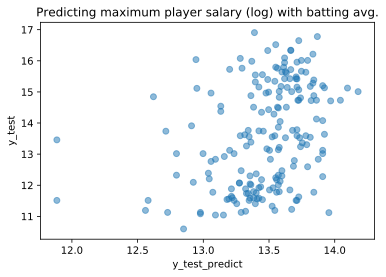

In [67]:
# plt.scatter(X_train, y_train)
plt.scatter(model.predict(X_test),y_test, alpha=0.5)
plt.xlabel('y_test_predict')
plt.ylabel('y_test')
plt.title('Predicting maximum player salary (log) with batting avg.')
plt.savefig('MVP.png');

In [ ]:
rookie_player_pages = pd.read_csv('data/rookie_player_pages.csv', index_col=0)

In [ ]:
rookie_player_pages[rookie_player_pages.html.isnull() == False].shape

In [ ]:
scrapped_rookie_players = rookie_player_pages[rookie_player_pages.html.isnull() == False]
scrapped_rookie_players.reset_index(inplace=True)

In [ ]:
df.loc[df.Salary == '', 'Salary'] = np.nan
df.Salary = df.Salary.astype(float)
df

In [ ]:
df = bb.load_salary_data(scrapped_rookie_players)

In [ ]:
df.head()

In [ ]:
# import time
start = time.time()
df = bb.load_salary_data(scrapped_rookie_players)
end = time.time()
print(end-start)

In [ ]:
min_year = df.groupby(['name','UID'])['Year'].min()
max_year = df.groupby(['name','UID'])['Year'].max()
join_year = pd.concat([min_year, max_year],axis=1)
join_year.columns = ['min_year','max_year']
join_year['year_diff'] = join_year.max_year.astype(int) - join_year.min_year.astype(int)
join_year[join_year.year_diff >= 6]

In [ ]:
df.name.value_counts().head()

In [ ]:
df[df.name=='Mike Figga']

In [ ]:
rookie_player_pages[rookie_player_pages.name == 'Matt Luke'].link[87]

In [ ]:
team = batting_df[batting_df.Year == '1998'].Tm
team.str.contains('-min')

In [ ]:
df[~df.Tm.str.contains('-min')]
~df.Tm.str.contains('-min',regex=False)

In [ ]:
df

In [ ]:
# rookie_player_pages.reset_index(inplace=True)
url = rookie_player_pages.html[0]
soup_players = BeautifulSoup(url, 'lxml')
year = str(rookie_player_pages.year[0])
name = str(rookie_player_pages.name[0])

# position = soup_players.find('p')
# position
# url
# position = position.contents[2].strip()
get_player_data(soup_players, year, name)

In [ ]:
rookie_df = build_rookie_table(rookie_pages, rookie_player_pages)
# rookie_df.reset_index()
# rookie_pages.loc[1998,:]

In [ ]:
rookie_df.sample(10)